In [2]:
conda install geopandas

Solving environment: done

## Package Plan ##

  environment location: /Users/chen/opt/anaconda3

  added / updated specs:
    - geopandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.27 |                0         131 KB
    cairo-1.14.12              |       hc4e6be7_4         860 KB
    certifi-2019.11.28         |           py37_0         156 KB
    cfitsio-3.470              |       hb33e7b4_2         823 KB
    click-plugins-1.1.1        |             py_0          11 KB
    cligj-0.5.0                |           py37_0          12 KB
    conda-4.8.1                |           py37_0         2.8 MB
    fiona-1.8.11               |   py37heeaa653_0         627 KB
    fontconfig-2.13.0          |       h5d5b041_1         202 KB
    freexl-1.0.5               |       h1de35cc_0          39 KB
    gdal-3.0.2                 |   py37hbe65578_0         1.6 MB


In [11]:
conda install descartes

Solving environment: done

## Package Plan ##

  environment location: /Users/chen/opt/anaconda3

  added / updated specs:
    - descartes


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    descartes-1.1.0            |             py_3           9 KB
    ------------------------------------------------------------
                                           Total:           9 KB

The following NEW packages will be INSTALLED:

  descartes          pkgs/main/noarch::descartes-1.1.0-py_3



descartes-1.1.0      | 9 KB      | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [1]:
import geopandas as gp
import fiona
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

In [2]:
NY_GEO = gp.read_file("nyc/geo_export_ed1b9dba-ece4-470b-8a1e-2954c9ff29fe.shp", driver='shapefile')
CITI = pd.read_csv('citi_df_sum.csv') #201911-citibike-tripdata.csv
NY_STATION = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')
NY_LINES = gp.read_file('line/geo_export_1600b818-1305-4ac8-b2d4-6d1ad4428095.shp')
TURNSTILE = pd.read_csv('turnstile/cleaned_turnstile_daily.csv')
#station = pd.read_csv("http://web.mta.info/developers/data/nyct/subway/Stations.csv")

In [3]:
def coord_start(row):
    return Point(row['start station longitude'], row['start station latitude'])

def line_up(row):
    return LineString([[row['start station longitude'], row['start station latitude']], [row['end station longitude'], row['end station latitude']]])

In [4]:
BLYN = NY_GEO[(NY_GEO.boro_name == 'Brooklyn')]

In [5]:
CITI_DF_END = gp.GeoDataFrame(
    CITI, 
    crs = {'init': 'epsg:4326'},
    geometry = gp.points_from_xy(CITI['end station longitude'], CITI['end station latitude']),
    )

In [6]:
TURNSTILE.head()

,Unnamed: 0,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
0,1,A002,R051,02-00-00,59 ST,01/02/2019,6893894,01/01/2019,6892430.0,1464.0
1,2,A002,R051,02-00-00,59 ST,01/03/2019,6895434,01/02/2019,6893894.0,1540.0
2,3,A002,R051,02-00-00,59 ST,01/04/2019,6896974,01/03/2019,6895434.0,1540.0
3,4,A002,R051,02-00-00,59 ST,01/05/2019,6897740,01/04/2019,6896974.0,766.0
4,5,A002,R051,02-00-00,59 ST,01/06/2019,6898382,01/05/2019,6897740.0,642.0


In [7]:
STATION_DF = gp.GeoDataFrame(
    NY_STATION, 
    crs = {'init': 'epsg:4326'},
    geometry = gp.points_from_xy(NY_STATION['GTFS Longitude'], NY_STATION['GTFS Latitude']))

In [8]:
# "clip" a points layer to the boundary of a polygon
#BLYN_CITI = CITI_DF[CITI_DF.geometry.intersects(BLYN.geometry.unary_union)]
BLYN_CITI_END = CITI_DF_END[CITI_DF_END.geometry.intersects(BLYN.geometry.unary_union)]

In [9]:
# "clip" a points layer to the boundary of a polygon
BLYN_STATION = STATION_DF[STATION_DF.geometry.intersects(BLYN.geometry.unary_union)]

In [10]:
# "clip" a points layer to the boundary of a polygon
BLYN_LINES = NY_LINES[NY_LINES.geometry.intersects(BLYN.geometry.unary_union)]

In [11]:
BLYN_STATION['geometry']=BLYN_STATION['geometry'].buffer(.002)

/Users/chen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
BLYN_CITI_END = CITI_DF_END[CITI_DF_END.geometry.intersects(BLYN_STATION.geometry.unary_union)]

In [26]:
BLYN_CITI_START = gp.GeoDataFrame(
    BLYN_CITI_END.copy(),
    crs = {'init': 'epsg:4326'},
    geometry = gp.points_from_xy(BLYN_CITI_END['start station longitude'], BLYN_CITI_END['start station latitude']),
    )

In [14]:
BLYN_CITI_PATH = gp.GeoDataFrame(
    BLYN_CITI_END.copy(),
    crs = {'init': 'epsg:4326'}    )

In [15]:
line_up = BLYN_CITI_PATH.apply(line_up, axis=1)
BLYN_CITI_PATH['geometry'] = line_up
BLYN_CITI_PATH.set_geometry('geometry')
BLYN_CITI_PATH;

In [32]:
BLYN_CITI_END.

,Unnamed: 0,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,counts,geometry
3,287376,3423.0,West Drive & Prospect Park West,40.661063,-73.979453,3423.0,West Drive & Prospect Park West,40.661063,-73.979453,5165,POINT (-73.97945 40.66106)
18,289928,3430.0,Richardson St & N Henry St,40.719079,-73.942237,3086.0,Graham Ave & Conselyea St,40.715143,-73.944507,4189,POINT (-73.94451 40.71514)
38,115770,460.0,S 4 St & Wythe Ave,40.712859,-73.965903,3093.0,N 6 St & Bedford Ave,40.717452,-73.958509,3678,POINT (-73.95851 40.71745)
50,127387,481.0,S 3 St & Bedford Ave,40.712605,-73.962644,3093.0,N 6 St & Bedford Ave,40.717452,-73.958509,3448,POINT (-73.95851 40.71745)
67,160549,2002.0,Wythe Ave & Metropolitan Ave,40.716887,-73.963198,3093.0,N 6 St & Bedford Ave,40.717452,-73.958509,3183,POINT (-73.95851 40.71745)
68,193933,3108.0,Nassau Ave & Russell St,40.725570,-73.944340,3668.0,Leonard St & Nassau Ave,40.723957,-73.949844,3151,POINT (-73.94984 40.72396)
73,26669,258.0,DeKalb Ave & Vanderbilt Ave,40.689407,-73.968855,324.0,DeKalb Ave & Hudson Ave,40.689888,-73.981013,3074,POINT (-73.98101 40.68989)
97,21088,244.0,Willoughby Ave & Hall St,40.691960,-73.965369,324.0,DeKalb Ave & Hudson Ave,40.689888,-73.981013,2852,POINT (-73.98101 40.68989)
147,32220,270.0,Adelphi St & Myrtle Ave,40.693083,-73.971789,239.0,Willoughby St & Fleet St,40.691966,-73.981302,2509,POINT (-73.98130 40.69197)
187,32273,270.0,Adelphi St & Myrtle Ave,40.693083,-73.971789,324.0,DeKalb Ave & Hudson Ave,40.689888,-73.981013,2304,POINT (-73.98101 40.68989)


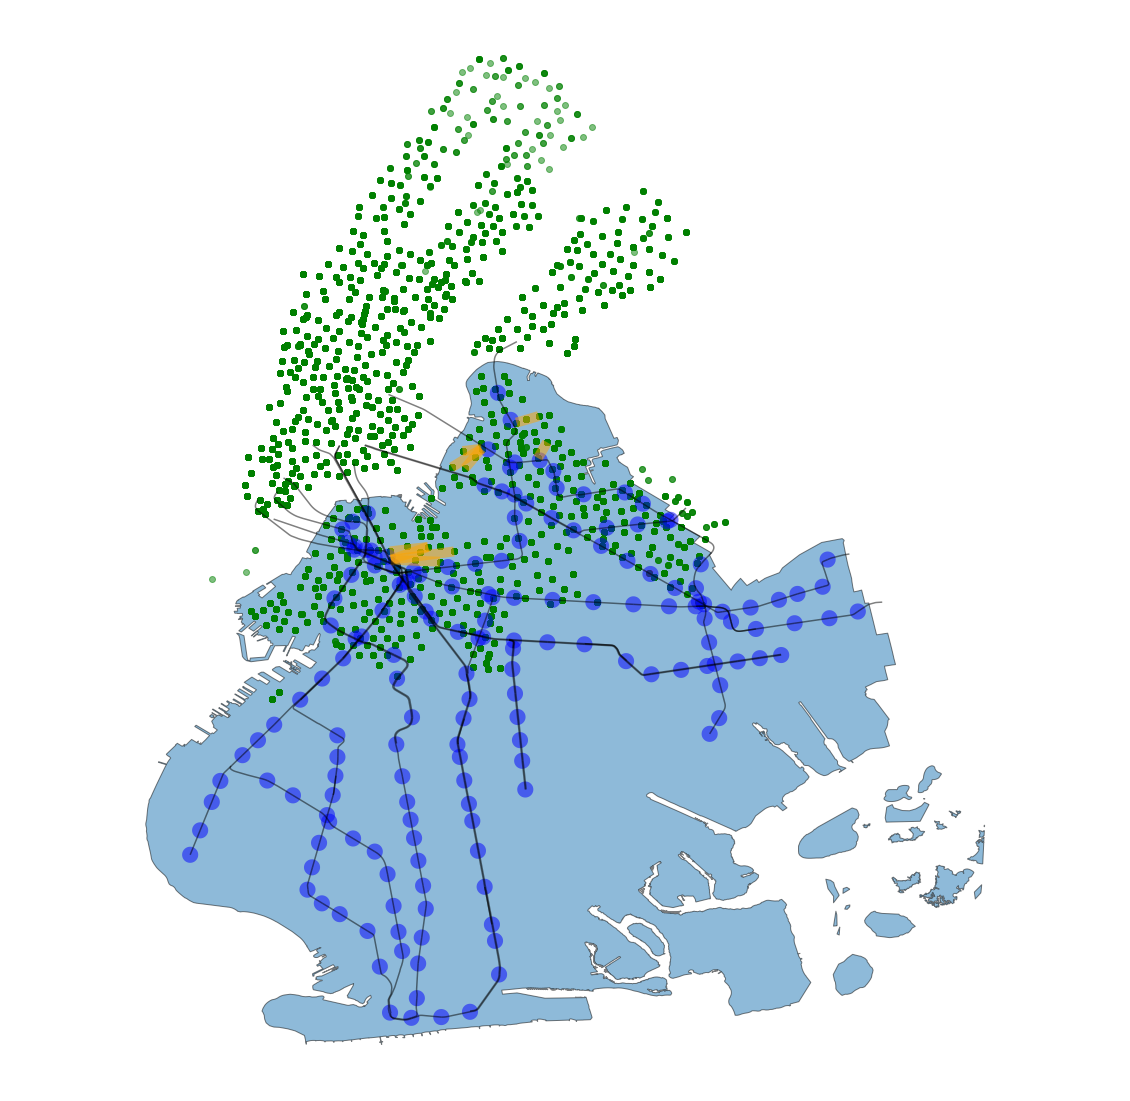

In [25]:
fig, ax = plt.subplots(figsize=(20, 20))
BLYN.plot(alpha=.5,edgecolor='black', ax=ax)
BLYN_CITI_PATH.head(10).plot(alpha=.5,color='orange',linewidth=10, ax=ax)
BLYN_CITI_END.plot(alpha=.5, marker='o', color='red', ax=ax)
BLYN_CITI_START.plot(alpha=.5, marker='o', color='green', ax=ax)
BLYN_STATION.plot(alpha=.5, color='blue', ax=ax)
BLYN_LINES.plot(alpha=.5,color='black', ax=ax)
plt.axis('equal')
ax.set_axis_off()